<a href="https://colab.research.google.com/github/Soham-Kamat/MLProject_NetflixRecommendationSystem/blob/main/NetflixMovieRecommendationSys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#This file has to be installed Locally to run surprise
!pip install surprise

     |████████████████████████████████| 11.8MB 3.5MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617615 sha256=b54fcf64ea9159a86f3d7fe1482c9bba225a7c810edaec1131ea5d67dfc7c30c
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [30]:
'''
Topic-Netflix Movie Recommendation system
Algorithms USed
1.SVD
2.Pearson R Correlation

Files used-
dataset.txt
movie_titles.csv...Uploaded in the respository.

Group-
1.Harshita Mishra 40 D12C
2.Soham Kamat 28 D12C

'''


#All the modules are imported here
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")


In [60]:
'''
df1 dataset looks like this
1:
983686     3.0  2001-11-06
953667     4.0  2005-02-27
2:
2000000  1910904     5.0  2005-07-06
so..on

This means Movie id 1 has been watched by customer_id 983686 on 2001-11-06 and the user rated 3.0
Similarly for all other rows.

dataset.txt contains 23L records
'''

df = pd.read_csv('dataset.txt', header = None, names = ['Cust_Id', 'Rating','Date'], usecols = [0,1,2])

df['Rating'] = df['Rating'].astype(float)
#.shape() tells rows*colms

print('Dataset 1 shape: {}'.format(df1.shape))
print('Dataset 1 examples-')
print(df1.iloc[::500000, :])  #integer index based =iloc

Dataset 1 shape: (2344156, 3)
Dataset 1 examples-
         Cust_Id  Rating        Date
0             1:     NaN         NaN
500000    983686     3.0  2001-11-06
1000000   953667     4.0  2005-02-27
1500000  1253590     4.0  2005-01-07
2000000  1910904     5.0  2005-07-06


         count
Rating        
1.0     108024
2.0     230940
3.0     658749
4.0     815439
5.0     530560


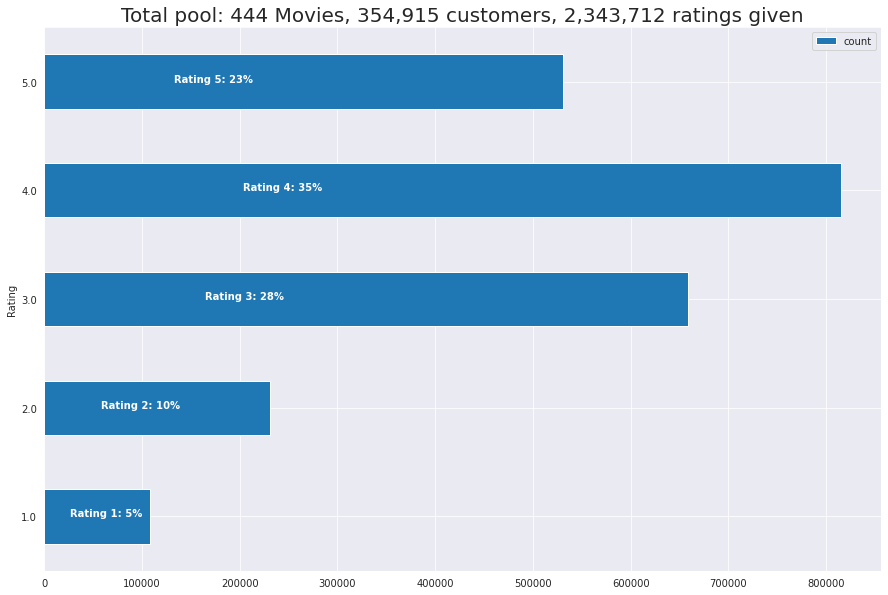

In [62]:
'''
Data Viweing is done here

The dataset contains NaN in Rating and Date colums where There is a movie id ,using that we calculate number of movies.
After that displaying count of CustomersRating given and Movies in the form of a bar graph

Rating scale is out of 5.The bar graph shows the percentage of users who voted for a particular rating.



'''

p = df.groupby('Rating')['Rating'].agg(['count'])
print(p)

# get movie count
# print(df.isnull().sum()[0])
movie_count = df.isnull().sum()[1]
# print(movie_count)

# get customer count
# print(df['Cust_Id'])
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = True, figsize = (15,10))
# print(ax)
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('on')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

In [63]:
'''
In this cell ,we create a movie numpy aray to count how mnay times each movie has been reviewed.

'''

df_nan = pd.DataFrame(pd.isnull(df.Rating))
print(df_nan)
df_nan = df_nan[df_nan['Rating'] == True]
# print(df_nan)
df_nan = df_nan.reset_index()
# print(df_nan)

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    # print(temp.shape)
    movie_np = np.append(movie_np, temp) #append will add to that array 
    # print(movie_np)
    movie_id += 1


# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)
# print(movie_np[574])
print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))


         Rating
0          True
1         False
2         False
3         False
4         False
...         ...
2344151   False
2344152   False
2344153   False
2344154   False
2344155    True

[2344156 rows x 1 columns]
Movie numpy: [  1.   1.   1. ... 443. 443. 443.]
Length: 2343712


In [64]:
'''
Appending the movie_np to our previous dataset i.e df
'''


df = df[pd.notnull(df['Rating'])]
# print(df)

df['Movie_Id'] = movie_np.astype(int) #append movie id list to df
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::10000, :])#Now we have customer rating matched with respective movie_id


-Dataset examples-
         Cust_Id  Rating        Date  Movie_Id
1        1488844     3.0  2005-09-06         1
10008    2421394     3.0  2005-06-01         8
20008    1834737     3.0  2005-10-22         8
30017    1572097     4.0  2005-07-25        17
40018    2304974     3.0  2001-11-24        18
...          ...     ...         ...       ...
2300442  1214824     5.0  2004-10-05       442
2310442  1572040     5.0  2005-12-04       442
2320443   240084     3.0  2005-09-01       443
2330443    35616     4.0  2004-07-09       443
2340443  2531475     4.0  2005-09-15       443

[235 rows x 4 columns]


In [65]:
'''
Data cleaning starts here,as the file is very large we want to trim it iorder make the kernel give fast results.

Using the count for each movie_id we alculate its mean i.e the mean rating for a particular movie
Now,using quantile we set a benchmark i.e min likes for which a movie must be selected.Rest movies will be trimmed out of the 
movie dataset.

Here the calculated benchmark is 2171 reviews

Similarly for customer minimum reviews are 7.0 ,other customer which have reviewed less than 7 movies will be trimmed 
out of dataset.


'''
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
 #find count and mean of each movie_id....movie_id 1 has count 547 and average rating 3.74
print(df_movie_summary)
df_movie_summary.index = df_movie_summary.index.map(int)
# print(type(df_movie_summary.index))
# print(df_movie_summary)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0) #70% quantile...setting benchmark
#2171 should be min likes for a movie
print(movie_benchmark)
#Dropping those movies having likes(count) less than 2171
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index #Trimming data
# print(drop_movie_list)  #New List contains only 310 movies
print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
print(df_cust_summary) #Average Rating given by a customer
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
#Only those customers who have liked min 7 movies
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

          count      mean
Movie_Id                 
1           547  3.749543
2           145  3.558621
3          2012  3.641153
4           142  2.739437
5          1140  3.919298
...         ...       ...
439         688  3.216570
440         107  2.925234
441         340  3.770588
442       25292  3.934129
443       29209  3.976240

[443 rows x 2 columns]
2171.0
Movie minimum times of review: 2171.0
         count      mean
Cust_Id                 
6           11  3.363636
7           16  4.562500
10           5  3.200000
25           1  3.000000
33           1  4.000000
...        ...       ...
2649401      3  3.666667
2649404      2  3.500000
2649409      3  3.666667
2649426     11  4.272727
2649429      4  4.750000

[354915 rows x 2 columns]
Customer minimum times of review: 7.0


In [66]:
#After trimming the dataset contains less values
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::5000000, :])

Original Shape: (2343712, 4)
After Trim Shape: (1595440, 4)
-Data Examples-
      Cust_Id  Rating        Date  Movie_Id
5106   824097     2.0  2005-07-08         8


In [67]:
'''
This is the movies dataset that is the total list of movies in netflix database which are 17770 out of which all customers 
have only seen 440 movies.
'''
df_title = pd.read_csv('movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
print(df_title.shape) # 17770 Movies in movies list
print (df_title.head(20))#First 20 Movies 



(17770, 2)
            Year                                               Name
Movie_Id                                                           
1         2003.0                                    Dinosaur Planet
2         2004.0                         Isle of Man TT 2004 Review
3         1997.0                                          Character
4         1994.0                       Paula Abdul's Get Up & Dance
5         2004.0                           The Rise and Fall of ECW
6         1997.0                                               Sick
7         1992.0                                              8 Man
8         2004.0                         What the #$*! Do We Know!?
9         1991.0                           Class of Nuke 'Em High 2
10        2001.0                                            Fighter
11        1999.0                     Full Frame: Documentary Shorts
12        1947.0                               My Favorite Brunette
13        2003.0  Lord of the Rings: 

In [68]:

df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')# Putting data in matrix form
print(df_p)
print(df_p.shape)


Movie_Id  8    16   17   18   26   28   30   ...  431  432  433  436  438  442  443
Cust_Id                                      ...                                   
6         NaN  NaN  NaN  NaN  NaN  NaN  3.0  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN
7         5.0  NaN  NaN  NaN  NaN  4.0  5.0  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN
79        NaN  NaN  NaN  NaN  NaN  NaN  3.0  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN
87        NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN
97        NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  5.0
...       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
2649335   NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  3.0
2649336   4.0  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2649378   NaN  NaN  NaN  NaN  NaN  3.0  3.0  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2649388   NaN  NaN  NaN  NaN  NaN  NaN  3.0  ...  NaN  NaN  NaN  NaN  NaN  N

In [69]:
 '''
 This is the first Recommendation Model......Done by Soham Kamat D12C 28

We cross validate the dataset among different models for best results.

 '''
 reader = Reader()

# Selecting top 100K rows for faster run time
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:100000], reader)
#data.split(n_folds=3)

svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

{'fit_time': (4.767416000366211,
  4.762507915496826,
  4.818485260009766,
  4.778703212738037,
  4.822225093841553),
 'test_mae': array([0.80820108, 0.80128507, 0.78988519, 0.79569538, 0.80513223]),
 'test_rmse': array([1.00666336, 0.99997956, 0.99072155, 0.99818292, 0.99807259]),
 'test_time': (0.1412954330444336,
  0.15526723861694336,
  0.7137789726257324,
  0.1531202793121338,
  0.14369678497314453)}

In [70]:
'''
We want to predict results for user 785314...So we show the list of movies which have rating 5 because they are
user 785314 's fav. movies....
'''

df_785314 = df[(df['Cust_Id'] == 785314) & (df['Rating'] ==5)]
print(df_785314)
df_785314 = df_785314.set_index('Movie_Id')
df_785314 = df_785314.join(df_title)['Name']
print(df_785314)


         Cust_Id  Rating        Date  Movie_Id
258703    785314     5.0  2002-03-18        57
577616    785314     5.0  2002-03-15       175
1473265   785314     5.0  2004-11-09       311
1670799   785314     5.0  2003-03-21       329
1764097   785314     5.0  2002-05-23       331
Movie_Id
57        Richard III
175    Reservoir Dogs
311           Ed Wood
329             Dogma
331       Chasing Amy
Name: Name, dtype: object


In [78]:
'''
We use the trimmed datset of moviea sd create its copy for this user
Then, train it with SVD and
find the Estimate Score for user 785314 ,this score shows the likliood that
this user will like a particular movies
then we present the top 10 results having highest scores

'''
user_785314 = df_title.copy()
# print(user_785314)
user_785314 = user_785314.reset_index()
# print(user_785314)
user_785314 = user_785314[~user_785314['Movie_Id'].isin(drop_movie_list)]
# print(user_785314)

# getting full dataset
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)

trainset = data.build_full_trainset()
svd.fit(trainset)

user_785314['Estimate_Score'] = user_785314['Movie_Id'].apply(lambda x: svd.predict(785314, x).est)
print(user_785314)
user_785314 = user_785314.drop('Movie_Id', axis = 1)

user_785314 = user_785314.sort_values('Estimate_Score', ascending=False)
print(user_785314.head(10))


       Movie_Id  ...  Estimate_Score
7             8  ...        1.599816
15           16  ...        2.517176
16           17  ...        2.354928
17           18  ...        2.830198
25           26  ...        2.125460
...         ...  ...             ...
17765     17766  ...        3.123011
17766     17767  ...        3.123011
17767     17768  ...        3.123011
17768     17769  ...        3.123011
17769     17770  ...        3.123011

[17460 rows x 4 columns]
       Year                        Name  Estimate_Score
67   2004.0                 Invader Zim        4.388713
174  1992.0              Reservoir Dogs        4.356965
222  2003.0  Chappelle's Show: Season 1        4.344177
252  1935.0        A Night at the Opera        4.196450
179  2002.0                     Scratch        4.031613
310  1994.0                     Ed Wood        4.023784
328  1999.0                       Dogma        3.914913
56   1995.0                 Richard III        3.910403
240  1959.0          North

In [82]:
#This is matrix (Movie_Id  X Cust_Id) having rating 
print(df_p)

Movie_Id  8    16   17   18   26   28   30   ...  431  432  433  436  438  442  443
Cust_Id                                      ...                                   
6         NaN  NaN  NaN  NaN  NaN  NaN  3.0  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN
7         5.0  NaN  NaN  NaN  NaN  4.0  5.0  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN
79        NaN  NaN  NaN  NaN  NaN  NaN  3.0  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN
87        NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN
97        NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  5.0
...       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
2649335   NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  3.0
2649336   4.0  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2649378   NaN  NaN  NaN  NaN  NaN  3.0  3.0  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2649388   NaN  NaN  NaN  NaN  NaN  NaN  3.0  ...  NaN  NaN  NaN  NaN  NaN  N

In [80]:
'''
Here ,the 2nd Recommendation model starts using Peason R Correlation..Done by Harshita Mishra D12C 40
This model shows the highest 10 correlatons for a particular movie ..
for eg- If we see 3 idiots ,then this reslt shows the top 10 movies highly correlated 
with 3 idiots.


'''
def recommend(movie_title, min_count):
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = int(df_title.index[df_title['Name'] == movie_title][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    print(corr_target[corr_target['count']>min_count][:11].to_string(index=False))

In [81]:
'''
Searching Reults for Movie The 10th Kingom
'''
recommend("The 10th Kingdom", 0)

For movie (The 10th Kingdom)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                                  Name  count      mean
 1.000000                      The 10th Kingdom   4532  3.669903
 0.632151                               Scratch   2418  3.833747
 0.592618                           Invader Zim   2216  4.142599
 0.571494             Les Miserables in Concert   2714  3.988946
 0.544561  Winnie the Pooh: Springtime with Roo   2190  3.768037
 0.495298               The Weather Underground   5147  3.757140
 0.492261                            The Legend   3217  3.755051
 0.461465                        Justice League   3591  3.710944
 0.460061                            The Chorus   9151  4.092230
 0.457119                            Home Movie   2724  3.417401
 0.450127                         The Last Shot   3558  2.600056


In [ ]:
# Searching Results for Invader Zim Movie

recommend("Invader Zim",0)
 

For movie (Invader Zim)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                                            Name  count      mean
 1.000000                                     Invader Zim   2216  4.142599
 0.777647                                      Home Movie   2724  3.417401
 0.696973                                         Scratch   2418  3.833747
 0.650569                               Woman of the Year   5184  3.948495
 0.642192                                      The Chorus   9151  4.092230
 0.620012                                   The Last Shot   3558  2.600056
 0.610916                                     Dinner Rush   3482  3.470994
 0.605350                       The Bad and the Beautiful   2350  3.266383
 0.592618                                The 10th Kingdom   4532  3.669903
 0.578302  Neon Genesis Evangelion: The End of Evangelion   2375  3.911158
 0.569907                                 The Love Letter   2619  2.968690
